In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dropout

In [3]:
#TUTORIAL: https://heartbeat.fritz.ai/introduction-to-deep-learning-with-keras-c7c3d14e1527

df = pd.read_csv('dataset/ANN/training.csv')

#If you have categorical values, transform them to dummy variables
#feats = [‘policy_state’,’insured_sex’,’insured_education_level’,’insured_occupation’,’insured_hobbies’,’insured_relationship’,’collision_type’,’incident_severity’,’authorities_contacted’,’incident_state’,’incident_city’,’incident_location’,’property_damage’,’police_report_available’,’auto_make’,’auto_model’,’fraud_reported’,’incident_type’]
#df_final = pd.get_dummies(df,columns=feats,drop_first=True)

df.head()

,Unnamed: 0,lat,lon,date,speed,double_cross,time_in_range,cluster_proximity,searching
0,0,0.000000,0.000000,0,3.093136,0,0,0.232999,0
1,1,0.000000,0.000000,0,3.093136,0,0,0.232999,0
2,2,0.000039,-0.000033,1,4.294210,0,1,0.235498,0
3,3,0.000070,-0.000096,2,5.172045,0,2,0.239810,0
4,4,0.000122,-0.000167,3,6.448076,0,3,0.245374,0


In [6]:
#We drop useless columns
df_final = df.drop(['Unnamed: 0', 'lat', 'lon', 'date'],axis=1)#'date','lat', 'lon'

categories = np.unique(df_final["searching"])

columns = ['speed', 'double_cross', 'time_in_range', 'cluster_proximity']


#We make sure to drop the column we’re predicting to prevent it from leaking 
#into the training set and the test set. 
#We must avoid using the same dataset to train and test the model.

X = df_final.drop(['searching'],axis=1).values
y = df_final['searching'].values

X, y

(array([[3.09313560e+00, 0.00000000e+00, 0.00000000e+00, 2.32998684e-01],
        [3.09313560e+00, 0.00000000e+00, 0.00000000e+00, 2.32998684e-01],
        [4.29421002e+00, 0.00000000e+00, 1.00000000e+00, 2.35497885e-01],
        ...,
        [2.39999995e-01, 0.00000000e+00, 5.80000000e+01, 3.28557865e-03],
        [2.39999995e-01, 0.00000000e+00, 5.90000000e+01, 3.28557865e-03],
        [2.39999995e-01, 0.00000000e+00, 6.00000000e+01, 3.28557865e-03]]),
 array([0, 0, 0, ..., 1, 1, 1]))

In [7]:
#We then split the data into a training and test set. We use 0.7 of the data for training and 0.3 for testing.

#X_train represents the independent variables we’re using to train
#y_train represents the column we’re predicting

#X_test represents the independent variables we’re using to test
#y_test represents the column we’re predicting during tests

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)



In [63]:
#Feature scaling standardizes the range of our independent variables.
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [64]:
#Now we build the ANN
classifier = Sequential()

In [65]:
#We use the add method to add different layers to our ANN.

#We start with the first layer.

#The first parameter is the number of nodes you want to add to this layer.
#Common strategy: choose the number of nodes as the average of nodes in the input layer 
#and the number of nodes in the output layer. 
#In our case 4 independent variable in input, 1 output: 1+4=5/2=2.5=3

#The second parameter, kernel_initializer, is the function that will be used to initialize the weights.
#In this case, it will use a uniform distribution to make sure that the weights are small numbers close to zero

#The next parameter is the activation function. 
#We use the Rectifier function, shortened as ReLU. We mostly use this function for the hidden layer in ANN.

#The final parameter is input_dim, which is the number of nodes in the input layer. 
#It represents the number of independent variables. 
#In our case: 4

classifier.add(
        Dense(3, kernel_initializer = 'uniform',
              activation = 'relu', input_dim=len(columns)))

In [66]:
#Adding the second hidden layer
#We don’t need to specify the input_dim parameter because we have already specified it in the first hidden layer

classifier.add(
      Dense(3, kernel_initializer = 'uniform',
              activation = 'relu'))

In [67]:
#Adding the output hidden layer
#We change the first parameter because in our output node we expect one node

#We change the activation function because we want to get the probabilities that a claim is fraudulent. 
#We do this by using the Sigmoid activation function.

classifier.add(
     Dense(1, kernel_initializer = 'uniform',
           activation = 'sigmoid'))

In [68]:
#Compiling the ANN

#Compiling is basically applying a stochastic gradient descent to the whole neural network

#The second parameter is the loss function within the stochastic gradient algorithm. 
#Since our categories are binary, we use the binary_crossentropy

#The final argument is the criterion we’ll use to evaluate our model. 
#In this case we use the accuracy.

classifier.compile(optimizer= 'adam',
                  loss = 'binary_crossentropy',
                  metrics = ['accuracy'])

In [69]:
#Fitting our ANN to the training set

#Epochs represents the number of times we’re going to pass our full dataset through the ANN.
#Batch_size is the number of observations after which the weights will be updated.

# Hyper-parameters
BATCH_SIZE = 35
EPOCHS = 30


# fit model
#history = classifier.fit(X_train, y_train, validation_split=0.3, batch_size=BATCH_SIZE,epochs=EPOCHS, verbose=1)

In [70]:
#Making a single prediction

#new_pred = classifier.predict(sc.transform(np.array([[a,b,c,d]])))

#Where a,b,c,d represents our 4 features

#new_pred = (new_prediction > 0.5)

#NB: Since our classifier expects numpy arrays, 
#we have to transform the single observation into a numpy array and use the standard scaler to scale it.

In [71]:
#Evaluating the ANN

#After training the model one or two times, you’ll notice that you keep getting different accuracies

#This introduces the bias variance trade off. 
#In essence, we’re trying to train a model that will be accurate 
#and not have too much variance of accuracy when trained several times.

#We use the K-fold cross validation with K equal to 10. 
#This will split the training set into 10 folds. 
#We’ll then train our model on 9 folds and test it on the remaining fold.

#We’re going to do this iteratively through 10 combinations. 
#Each iteration will gives us its accuracy. We’ll then find the mean of all accuracies.
#We also calculate the variance to ensure that it’s minimal.

#Keras has a scikit learn wrapper (KerasClassifier) that enables us 
#to include K-fold cross validation in our Keras code.

#The KerasClassifier expects one of its arguments to be a function;
#the purpose of this function is to build the architecture of our ANN.


def make_classifier():
    classifier = Sequential()
    classifier.add(Dense(3, kernel_initializer = 'uniform', activation = 'relu', input_dim=len(columns)))
    classifier.add(Dense(3, kernel_initializer =  'uniform', activation = 'relu'))
    classifier.add(Dense(1, kernel_initializer =  'uniform', activation = 'sigmoid'))
    classifier.compile(optimizer= 'adam',loss = 'binary_crossentropy',metrics = ['accuracy'])
    return classifier

#Here we wrap our previous ANN architecture in a function and return the classifier.




In [72]:
#Create a new classifier using K-fold cross validation a
#and pass the parameter build_fn as the function we just created above.

classifier = KerasClassifier(build_fn = make_classifier,
                            batch_size=BATCH_SIZE, nb_epoch=EPOCHS)

#We train our classifier again
history = classifier.fit(X_train, y_train, validation_split=0.3, batch_size = BATCH_SIZE, epochs = EPOCHS)

Epoch 1/30
1153/1153 [==============================] - 2s 2ms/step - loss: 0.5964 - accuracy: 0.6494 - val_loss: 0.5774 - val_accuracy: 0.6436
Epoch 2/30
1153/1153 [==============================] - 2s 1ms/step - loss: 0.5727 - accuracy: 0.6494 - val_loss: 0.5769 - val_accuracy: 0.6436
Epoch 3/30
1153/1153 [==============================] - 2s 1ms/step - loss: 0.5727 - accuracy: 0.6485 - val_loss: 0.5769 - val_accuracy: 0.6436
Epoch 4/30
1153/1153 [==============================] - 2s 1ms/step - loss: 0.5725 - accuracy: 0.6479 - val_loss: 0.5768 - val_accuracy: 0.6436
Epoch 5/30
1153/1153 [==============================] - 2s 1ms/step - loss: 0.5720 - accuracy: 0.6494 - val_loss: 0.5761 - val_accuracy: 0.6436
Epoch 6/30
1153/1153 [==============================] - 2s 1ms/step - loss: 0.5689 - accuracy: 0.6716 - val_loss: 0.5712 - val_accuracy: 0.6766
Epoch 7/30
1153/1153 [==============================] - 2s 2ms/step - loss: 0.5649 - accuracy: 0.6833 - val_loss: 0.5674 - val_accuracy:

In [73]:
#Predicting using the training set

#This will show us the probability of a searching status.
#We then set a threshold of 50% for classifying a status as 'searching'.
#Any status with a probability of 0.5 or more will be classified as 'searching'.

y_pred = classifier.predict(X_test).astype("int32")
y_pred = (y_pred > 0.5)

print(y_pred)

[[ True]
 [False]
 [False]
 ...
 [ True]
 [False]
 [False]]


In [74]:
#Checking the confusion matrix

cm = confusion_matrix(y_test, y_pred)

cm

array([[13765,  2221],
       [ 5366,  3353]])

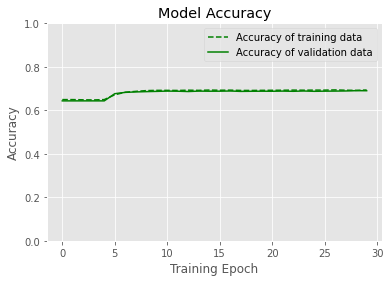

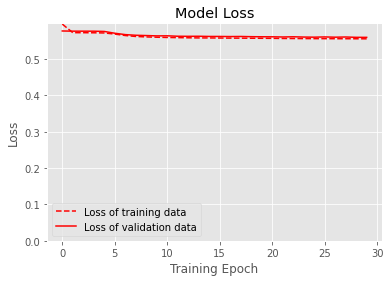

In [75]:
# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Training Epoch')
axes = plt.gca()
axes.set_ylim([0,1])
plt.ylim(0)
plt.legend()
plt.show()

# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [76]:
#This function will return the ten accuracies of the ten test folds used in the computation.

#n_jobs=-1 will make use of all available CPUs. 
#cv is the number of folds and 10 is a typical choice.

accuracies = cross_val_score(estimator = classifier,
                             X = X_train,
                             y = y_train,
                             cv = 10,
                             n_jobs = -1)

accuracies

array([0.65255857, 0.63937557, 0.69210756, 0.66394866, 0.68528801,
       0.68459404, 0.64555866, 0.65405971, 0.6384455 , 0.63827205])

In [77]:
#To obtain the relative accuracies we get the mean of the accuracies.

mean = accuracies.mean()

#Then the variance.

variance = accuracies.var()

#Goal: to have a small variance between the accuracies.

mean, variance

(0.6594208300113678, 0.00039487651477049474)

In [21]:
#Fighting Overfitting

#Overfitting in machine learning is what happens when a model learns the details and noise in the training set 
#such that it performs poorly on the test set -> it happens  when we have huge differences between 
#the accuracies of the test set and training set, 
#or when you observe a high variance when applying k-fold cross validation.

#In ANN, we counteract this using the Dropout Regularization technique, which works by randomly disabling 
#some neurons at each iteration of the training 
#to prevent them from being too dependent on each other.

classifier = Sequential()
classifier.add(Dense(3, kernel_initializer = 'uniform', activation = 'relu', input_dim=len(columns)))

# Notice the dropouts
classifier.add(Dropout(rate = 0.1))
classifier.add(Dense(6, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dropout(rate = 0.1))

#We used dropout after the first hidden layer and after the second hidden layer
#Rate of 0.1 means that 1% of the neurons will be disabled at each iteration. 
#It should be always between 0.1 and 0.4 (to avoid underfitting)

classifier.add(Dense(1, kernel_initializer = 'uniform', activation = 'sigmoid'))
classifier.compile(optimizer= 'adam',loss = 'binary_crossentropy',metrics = ['accuracy'])

In [22]:
#Parameter Tuning

#Tune the parameters to get a higher accuracy

#Modify our make_classifier
#Create a new variable called optimizer 
#that will allow us to add more than one optimizer in our params variable
#(earlier we were using only the Adam algorithm)

def make_classifier(optimizer):
    classifier = Sequential()
    classifier.add(Dense(3, kernel_initializer = 'uniform', activation = 'relu', input_dim=len(columns)))
    classifier.add(Dense(3, kernel_initializer =  'uniform', activation = 'relu'))
    classifier.add(Dense(1, kernel_initializer =  'uniform', activation = 'sigmoid'))
    classifier.compile(optimizer= optimizer,loss = 'binary_crossentropy',metrics = ['accuracy'])
    return classifier



In [23]:
#We’ll still use the KerasClassifier, 
#but we won’t pass the batch size and number of epochs 
#since these are the parameters we want to tune.

classifier = KerasClassifier(build_fn = make_classifier)

#Create a dictionary with the parameters we’d like to tune 

params = {
    'batch_size':[20,35],
    'nb_epoch':[150,500],
    'optimizer':['adam','rmsprop']
}

#We then use Grid Search to test these parameters.
#It expects our estimator, the parameters we just defined, the scoring metric and the number of k-folds.

grid_search = GridSearchCV(estimator=classifier,
                           param_grid=params,
                           scoring='accuracy',
                           cv=10)

In [68]:
#we need to fit our training set.

grid_search = grid_search.fit(X_train,y_train)

#we get the best selection of parameters using best_params from the grid search object

best_param = grid_search.best_params_

#we get the best accuracy score using best_score_

best_accuracy = grid_search.best_score_

#NB: this process will take a while

best_param, best_accuracy


2405/2405 [==============================] - 2s 1ms/step - loss: 0.5895 - accuracy: 0.6650
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
2672/2672 [==============================] - 3s 1ms/step - loss: 0.6233 - accuracy: 0.6654


({'batch_size': 20, 'nb_epoch': 500, 'optimizer': 'adam'}, 0.6671976538966404)